In [1]:
import os
import cv2
import numpy as np
import tensorflow as tf
import pandas as pd
import glob
from matplotlib import pyplot as plt

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.callbacks import EarlyStopping



In [2]:
path = '/kaggle/input/asl-dataset/asl_dataset/asl_dataset' 

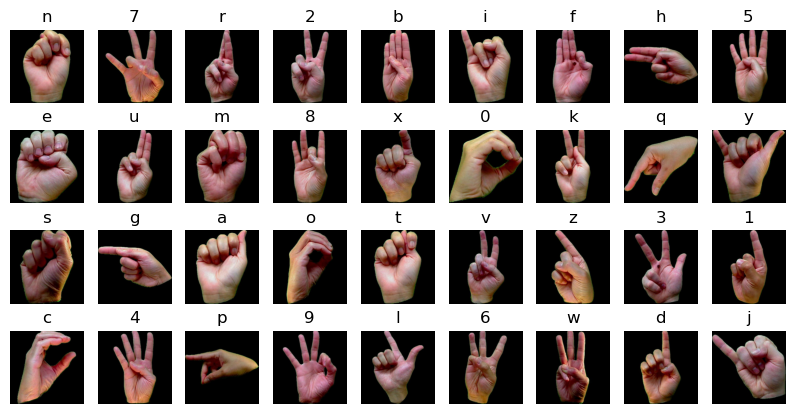

In [3]:
fig, ax = plt.subplots(4, 9, figsize=(10, 5))

img_classes = [os.path.join(path, im) for im in os.listdir(path)]

ax = ax.flatten()

for i, img_class in enumerate(img_classes):
    img = os.listdir(img_class)[np.random.randint(0, 10)]
    img_path = os.path.join(img_class, img)
    image = cv2.imread(img_path)
    ax[i].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    ax[i].set_title(os.path.basename(img_class))
    ax[i].axis('off')

plt.show()

In [4]:
for folder in os.listdir(path):
    folder_path = os.path.join(path, folder)
    image_files = glob.glob(os.path.join(folder_path, '*.jpeg'))
    num_images = len(image_files)
    print(folder, 'Number of images in folder:', num_images)

n Number of images in folder: 70
7 Number of images in folder: 70
r Number of images in folder: 70
2 Number of images in folder: 70
b Number of images in folder: 70
i Number of images in folder: 70
f Number of images in folder: 70
h Number of images in folder: 70
5 Number of images in folder: 70
e Number of images in folder: 70
u Number of images in folder: 70
m Number of images in folder: 70
8 Number of images in folder: 70
x Number of images in folder: 70
0 Number of images in folder: 70
k Number of images in folder: 70
q Number of images in folder: 70
y Number of images in folder: 70
s Number of images in folder: 70
g Number of images in folder: 70
a Number of images in folder: 70
o Number of images in folder: 70
t Number of images in folder: 65
v Number of images in folder: 70
z Number of images in folder: 70
3 Number of images in folder: 70
1 Number of images in folder: 70
c Number of images in folder: 70
4 Number of images in folder: 70
p Number of images in folder: 70
9 Number o

In [5]:
# Path dataset asli
original_dataset_dir = '/kaggle/input/asl-dataset/asl_dataset'

# Path tujuan split data
train_dir = '/kaggle/working/asl_dataset/train'
test_dir = '/kaggle/working/asl_dataset/test'

# Buat direktori tujuan jika belum ada
os.makedirs(train_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)


In [6]:
def split_data(source_dir, train_dir, test_dir, train_ratio=0.8):
    for label in os.listdir(source_dir):
        label_path = os.path.join(source_dir, label)
        if not os.path.isdir(label_path):  # Lewati jika bukan folder
            continue

        # Ambil semua file gambar di dalam folder kelas
        files = os.listdir(label_path)
        files = [f for f in files if os.path.isfile(os.path.join(label_path, f))]

        # Lewati jika folder kelas kosong
        if len(files) == 0:
            print(f"Folder kosong ditemukan untuk label: {label}, melewati...")
            continue

        # Bagi data menjadi train dan test
        train_files, test_files = train_test_split(files, train_size=train_ratio, random_state=42)

        # Buat subdirektori untuk masing-masing kelas di train dan test
        os.makedirs(os.path.join(train_dir, label), exist_ok=True)
        os.makedirs(os.path.join(test_dir, label), exist_ok=True)

        # Pindahkan file ke folder train
        for file in train_files:
            src = os.path.join(label_path, file)
            dst = os.path.join(train_dir, label, file)
            shutil.copy(src, dst)

        # Pindahkan file ke folder test
        for file in test_files:
            src = os.path.join(label_path, file)
            dst = os.path.join(test_dir, label, file)
            shutil.copy(src, dst)

    print("Proses splitting selesai.")


In [7]:
from sklearn.model_selection import train_test_split
import shutil

split_data(original_dataset_dir, train_dir, test_dir)

Folder kosong ditemukan untuk label: asl_dataset, melewati...
Proses splitting selesai.


In [9]:
# Path direktori train dan test
train_dir = '/kaggle/working/asl_dataset/train'
test_dir = '/kaggle/working/asl_dataset/test'

# Data augmentation untuk dataset train
train_datagen = ImageDataGenerator(
    rescale=1.0/255,  # Normalisasi pixel [0, 1]
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Generator untuk dataset test (hanya normalisasi)
test_datagen = ImageDataGenerator(rescale=1.0/255)

# Membaca dataset train dan test
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(64, 64),  # Resolusi gambar
    batch_size=32,
    class_mode='categorical'  # Karena klasifikasi multi-kelas
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(64, 64),
    batch_size=32,
    class_mode='categorical'
)


Found 2012 images belonging to 36 classes.
Found 503 images belonging to 36 classes.


In [10]:
model = Sequential([
    
    Conv2D(8, (3, 3), activation='relu', input_shape=(64, 64, 3), padding='same'),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(16, (3, 3), activation='relu', padding='same'),
    MaxPooling2D(pool_size=(2, 2)),
    

    Conv2D(32, (3, 3), activation='relu', padding='same'),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(32, (3, 3), activation='relu', padding='same'),
    MaxPooling2D(pool_size=(2, 2)),
    

    Conv2D(64, (3, 3), activation='relu', padding='same'),
    MaxPooling2D(pool_size=(2, 2)),
    
    # Flatten and Dense layers
    Flatten(),
    Dense(128, activation='relu'),
    Dense(train_generator.num_classes, activation='softmax')  # Output layer
])

# Compile model
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Summary model
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 8)         224       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 32, 32, 8)        0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 16)        1168      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 16, 16, 16)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 16, 16, 32)        4640      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 8, 8, 32)         0

In [11]:
# Definisikan EarlyStopping
early_stopping = EarlyStopping(
    monitor='val_loss',  # Metrik yang dipantau (validasi loss)
    patience=10,          # Hentikan jika tidak ada perbaikan setelah 5 epoch
    restore_best_weights=True,  # Kembalikan bobot terbaik
    verbose=1            # Tampilkan informasi ketika pelatihan dihentikan
)

In [12]:
# Melatih model dengan EarlyStopping
history = model.fit(
    train_generator,
    epochs=100,  # Set jumlah epoch yang tinggi
    validation_data=test_generator,
    callbacks=[early_stopping]  # Tambahkan EarlyStopping di sini
)


Epoch 1/100
63/63 [==============================] - 23s 132ms/step - loss: 3.5729 - accuracy: 0.0328 - val_loss: 3.4212 - val_accuracy: 0.0219
Epoch 2/100
63/63 [==============================] - 8s 124ms/step - loss: 3.1909 - accuracy: 0.0875 - val_loss: 2.6287 - val_accuracy: 0.1730
Epoch 3/100
63/63 [==============================] - 8s 125ms/step - loss: 2.7149 - accuracy: 0.1705 - val_loss: 2.2243 - val_accuracy: 0.2425
Epoch 4/100
63/63 [==============================] - 8s 126ms/step - loss: 2.4094 - accuracy: 0.2381 - val_loss: 1.8540 - val_accuracy: 0.3897
Epoch 5/100
63/63 [==============================] - 8s 124ms/step - loss: 2.1501 - accuracy: 0.3166 - val_loss: 1.5202 - val_accuracy: 0.4433
Epoch 6/100
63/63 [==============================] - 8s 124ms/step - loss: 1.8895 - accuracy: 0.3539 - val_loss: 1.4805 - val_accuracy: 0.4771
Epoch 7/100
63/63 [==============================] - 8s 123ms/step - loss: 1.7438 - accuracy: 0.4041 - val_loss: 1.2771 - val_accuracy: 0.510

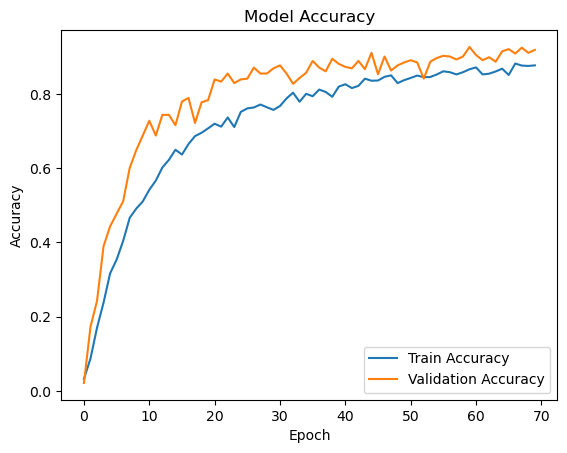

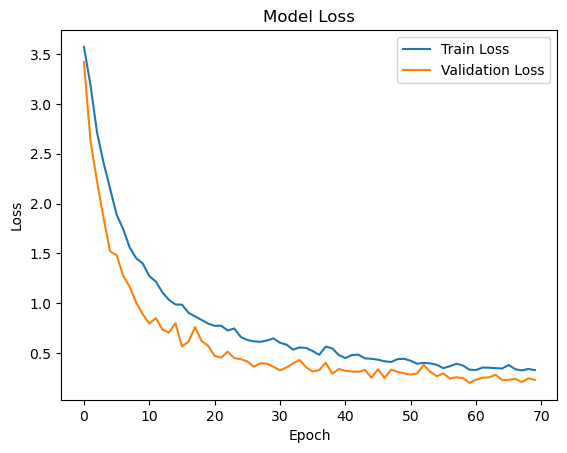

In [13]:
# Plot akurasi
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [14]:
# Evaluasi model
loss, accuracy = model.evaluate(test_generator)
print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")

16/16 [==============================] - 1s 66ms/step - loss: 0.1987 - accuracy: 0.9264
Test Loss: 0.1986638754606247
Test Accuracy: 0.9264413714408875


In [15]:
# Simpan model dalam format SavedModel
model.save("saved_model")

In [16]:
# Konversi model ke format TF-Lite
converter = tf.lite.TFLiteConverter.from_saved_model("/kaggle/working/saved_model")
tflite_model = converter.convert()

# Simpan model TF-Lite
with open("model.tflite", "wb") as f:
    f.write(tflite_model)

In [17]:
pip install tensorflowjs

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.1/89.1 kB 2.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.1/89.1 kB 7.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.1/89.1 kB 9.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.1/89.1 kB 7.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.1/89.1 kB 8.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.1/89.1 kB 8.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.2/89.2 kB 8.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.2/89.2 kB 7.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.2/89.2 kB 7.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.2/89.2 kB 8.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.2/89.2 kB 8.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.2/89.2 kB 5.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [18]:
!tensorflowjs_converter --input_format=tf_saved_model --output_format=tfjs_graph_model /kaggle/working/saved_model model_tfjs

In [19]:
import shutil

# Path to the directory you want to zip
dir_path = '/kaggle/working/'

# Path where the zip file will be saved
output_zip_path = '/kaggle/working/output.zip'

# Create a zip file
shutil.make_archive(output_zip_path.replace('.zip', ''), 'zip', dir_path)


'/kaggle/working/output.zip'